# Evaluating the power of classification directly from the SOM clustering

In [1]:
import os
import json
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve


In [2]:
filename_clusters = "som_iqa_loaded_results_5_clusters.parquet"
filename_mapping = "fits_objects_mapping.parquet.gz"
filename_labels = "map_images_labels.json"

data_path = "/home/mike/git/computational_astro/astro_iqa/data/"
file_path = os.path.join(data_path, "for_modeling")

In [3]:
# Reading clusters from the parquet file
print(f"Reading clusters from {os.path.join(file_path, filename_clusters)}")
clusters = pd.read_parquet(os.path.join(file_path, "Results", filename_clusters))
clusters = clusters.reset_index().rename(columns={'index': 'OBJECT_ID'})

# Reading fits / ground truth labels
print(f"Reading ground truth labels from {os.path.join(file_path, filename_labels)}")
with open(os.path.join(file_path, filename_labels), 'r') as f:
    labels_gt = json.load(f)


Reading clusters from /home/mike/git/computational_astro/astro_iqa/data/for_modeling/som_iqa_loaded_results_5_clusters.parquet
Reading ground truth labels from /home/mike/git/computational_astro/astro_iqa/data/for_modeling/map_images_labels.json


In [4]:
# Reading fits / object mapping
mapping_fits_obj = pd.read_parquet(os.path.join(file_path, filename_mapping), engine='auto')

In [5]:
# Transform into a dictionary in order to get columns
annotations_dict = {
    "Image_id": list(labels_gt["annotations"].keys()),
    "Label": list(labels_gt["annotations"].values())
}

annotations = pd.DataFrame(annotations_dict)

# A few corrections
# split multiple labels into separate columns
annotations[['Label1', 'Label2']] = annotations['Label'].str.split(', ', expand=True)
# Delete the original column
annotations = annotations.drop(columns=['Label'])
# Add a p to the Image_id column
annotations['Image_id'] = annotations['Image_id'].astype(str) + 'p'

print(labels_gt["categories"])

['GOOD', 'B_SEEING', 'BGP', 'BT', 'RBT']


In [6]:
# Encode ground truth labels
label_encoder = LabelEncoder()
label_encoder.fit(labels_gt["categories"])
print(label_encoder.classes_)
print(label_encoder.transform(labels_gt["categories"]))
print(label_encoder.transform(annotations[1:5]['Label1']))

['BGP' 'BT' 'B_SEEING' 'GOOD' 'RBT']
[3 2 0 1 4]
[2 2 3 2]


In [7]:
mapping_fits_obj["CLUSTER_ID"] = clusters.loc[clusters["OBJECT_ID"].isin(mapping_fits_obj["OBJECT_ID"]), "5_clusters"]

<Axes: >

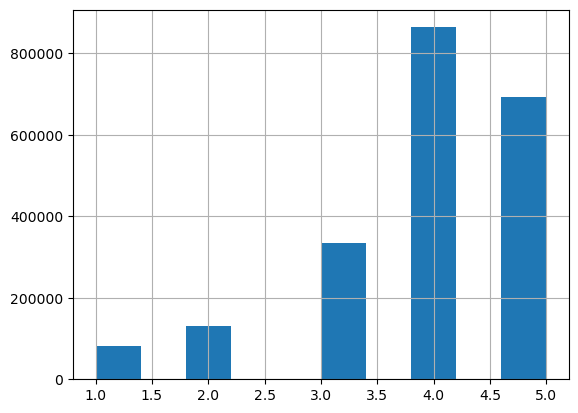

In [8]:
mapping_fits_obj["CLUSTER_ID"].hist()

<Axes: >

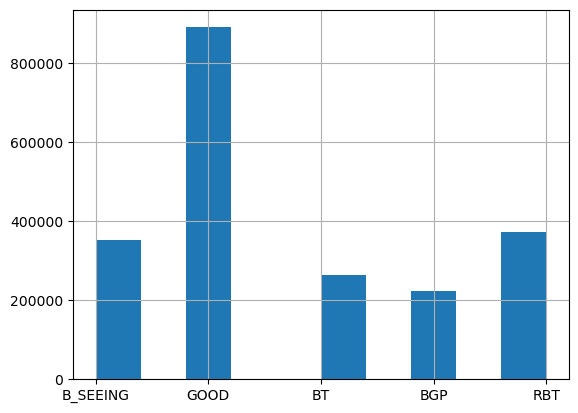

In [9]:
mapping_fits_obj["gt_label1"].hist()

## Measuring performances of the SOM clustering

### With the categories as defined in the label file


y_pred: min = 1, max = 5
['BGP' 'BT' 'B_SEEING' 'GOOD' 'RBT']


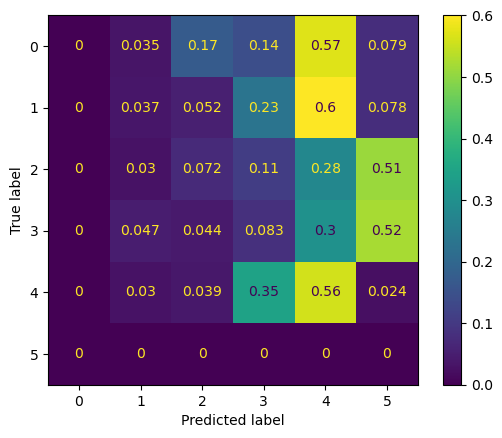

In [17]:
y_gt = label_encoder.transform(mapping_fits_obj["gt_label1"])
y_pred = clusters.loc[clusters["OBJECT_ID"].isin(mapping_fits_obj["OBJECT_ID"]), "5_clusters"]
print("y_pred: min = {}, max = {}".format(y_pred.min(), y_pred.max()))
cm = confusion_matrix(y_gt, y_pred, normalize='true')

print(label_encoder.classes_)
cm_display = ConfusionMatrixDisplay(cm).plot()

The confusion matrix shows:
- a pretty good power of separation with the clusters 4 and 5,
- a pretty good power of prediction of cluster 5 of good quality images and what we classified as "B_SEEING" images. A careful review of annotations shows that the classification "B_SEEING" of corresponding images is pretty severe. Examples of images 1625588p or 1853401p are closer of what is classified as good images in the original publication.
- the cluster 4 shows a good power of prediction on labels "BGP", "BT" and "RBT". The review of annotations "BGP" shows that corresponding images show anomalies probably related to the sensor itself. These images should be considered as anomalies regarding the current classification and so discarded. In consequence, the cluster 4 could show a good power of prediction on the labels "BT" and "RBT". These two classes may be considered as similar regarding features used. Further analysis is needed to confirm this hypothesis.

In conclusion, before going further in the modeling, we should review and correct annotations.